# Initialization

In [183]:
# Import packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind

# Clean the data set

In [184]:
# Import and clean data set

# df = pd.read_csv('datafile_fullynormalized.txt', sep='\t', header = 0, index_col = 2)
df = pd.read_excel('datafile_fullynormalized_collapsed.xlsx', header = 0, index_col = 2)

df.index.name = None
df.columns.name = "Gene"

# Drop columns by name
df.drop(['Protein', 'Molecule', 'UniProt'], axis=1, inplace=True)

df = df.dropna()

# z-score normalize the rows and columns of df_nolabels
df = df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
df = df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# Copy header as a new row
df.loc['Participant'] = [p[0] for p in df.columns]

# Replace C with "Control"
# Replace P with "Patient"
df.loc['Participant'] = df.loc['Participant'].replace('C', 'Control')
df.loc['Participant'] = df.loc['Participant'].replace('P', 'Patient')

# transpose the original df for future use (volcano plot)
df_transposed = df.T

In [185]:
df

Gene,C1,C2,C3,C4,C5,C8,C9,C11,C14,C15,...,P20,P21,P24,P25,P27,P28,P29,P30,P31,P32
A1BG,0.091205,7.078895,1.069358,-0.410483,0.090994,-0.391397,-0.482971,0.155578,0.292637,0.16033,...,0.209466,-0.475721,-0.425574,0.141805,-0.048056,-0.813057,0.396161,-0.400275,-0.527712,-1.000185
A1CF,-0.366126,-0.189053,-0.191105,-0.447277,-0.284493,-0.293338,-0.274342,-0.461104,-0.713775,1.576058,...,0.547655,0.083328,-0.188776,-0.038749,-0.493015,-0.452296,0.02767,-0.084262,-0.583087,-0.074083
A2M,-1.446105,0.419728,0.994347,0.976399,-0.790543,-0.042582,-0.595659,-0.083005,-1.679806,0.217666,...,3.001226,-0.1145,-0.032125,-1.587779,-0.560666,-0.186923,0.818539,-1.103836,-1.049004,-1.656604
A2ML1,-0.549432,-0.361978,0.448254,-0.608533,0.232591,-0.514884,-0.505113,0.029682,-0.819734,-0.058552,...,3.797887,3.032225,-0.298111,0.473307,1.054623,-0.780598,-0.061627,0.003301,-0.408577,-0.007879
A4GALT,-0.536944,0.003758,-0.98269,0.05802,-0.989209,-1.274313,-0.747419,-0.468004,-0.820285,0.488821,...,0.821062,0.504476,1.69912,-1.307813,0.155162,-1.122708,0.296385,-0.093287,-0.314558,-1.313228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZPLD1,0.16983,0.733269,-0.064138,0.053915,-0.254261,-0.435583,0.099608,-0.272006,6.092002,-0.531452,...,-0.085942,-0.228616,-0.678016,-0.620323,-0.522032,-0.776342,0.258578,-0.689597,-1.024366,-0.115197
ZWILCH,1.073171,0.101965,0.978747,1.12973,1.329205,-0.540338,0.981353,0.572758,0.461969,-0.545974,...,-1.102348,-1.502851,-0.317333,0.08665,1.693619,-0.131491,0.841043,0.673976,0.094064,0.854212
ZWINT,-0.474608,-0.240045,-0.256897,0.674238,0.231543,-0.765723,-0.48687,-0.678586,-0.057444,0.34744,...,-0.574639,0.253108,0.487093,0.008524,0.054439,-0.580242,0.461335,-0.162976,-0.295114,0.270262
ZYX,-1.442735,1.236425,-0.46137,1.033261,-0.825308,-0.616618,-0.646738,0.322707,0.302116,0.462984,...,0.661419,-1.025343,-0.305896,1.205859,-0.031828,0.699456,-0.872965,-0.620197,0.882945,0.184782


In [186]:
# how to make the first box of the first row "gene"
df_transposed.columns.name = "Gene"


In [187]:
# Prepare for heat map

participant_labels = df.loc['Participant', :]
df_nolabels = df.drop('Participant', axis=0)

color_map = {'Patient': 'orange', 'Control': (0.32628988850442137, 0.6186236063052672, 0.802798923490965)}
col_colors = participant_labels.map(color_map)

In [188]:
# drop below the 2.5th percentile and above the 97.5th percentile (i.e., outliers)
df_nolabels = df_nolabels.apply(lambda x: np.clip(x, x.quantile(0.025), x.quantile(0.975)), axis=1)

df_nolabels = df_nolabels.apply(pd.to_numeric, errors = "coerce")

In [189]:
df_nolabels

Gene,C1,C2,C3,C4,C5,C8,C9,C11,C14,C15,...,P20,P21,P24,P25,P27,P28,P29,P30,P31,P32
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.091205,1.219596,1.069358,-0.410483,0.090994,-0.391397,-0.482971,0.155578,0.292637,0.160330,...,0.209466,-0.475721,-0.425574,0.141805,-0.048056,-0.813057,0.396161,-0.400275,-0.527712,-1.000185
A1CF,-0.366126,-0.189053,-0.191105,-0.447277,-0.284493,-0.293338,-0.274342,-0.461104,-0.713775,1.576058,...,0.547655,0.083328,-0.188776,-0.038749,-0.493015,-0.452296,0.027670,-0.084262,-0.583087,-0.074083
A2M,-1.446105,0.419728,0.994347,0.976399,-0.790543,-0.042582,-0.595659,-0.083005,-1.657184,0.217666,...,1.601749,-0.114500,-0.032125,-1.587779,-0.560666,-0.186923,0.818539,-1.103836,-1.049004,-1.656604
A2ML1,-0.549432,-0.361978,0.448254,-0.608533,0.232591,-0.514884,-0.505113,0.029682,-0.819734,-0.058552,...,3.051367,3.032225,-0.298111,0.473307,1.054623,-0.780598,-0.061627,0.003301,-0.408577,-0.007879
A4GALT,-0.536944,0.003758,-0.982690,0.058020,-0.989209,-1.274313,-0.747419,-0.468004,-0.820285,0.488821,...,0.821062,0.504476,1.699120,-1.307813,0.155162,-1.122708,0.296385,-0.093287,-0.314558,-1.307949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZPBP2,-0.394226,-0.187077,-1.032870,0.442088,-1.254042,-0.372421,-0.300965,-0.504577,-0.698374,1.945627,...,0.269205,1.213764,-0.849999,0.401644,-1.209067,-1.261286,0.030626,-0.481358,-1.010244,-0.882870
ZPLD1,0.169830,0.733269,-0.064138,0.053915,-0.254261,-0.435583,0.099608,-0.272006,2.215699,-0.531452,...,-0.085942,-0.228616,-0.678016,-0.620323,-0.522032,-0.776342,0.258578,-0.689597,-0.828330,-0.115197
ZWILCH,1.073171,0.101965,0.978747,1.129730,1.329205,-0.540338,0.981353,0.572758,0.461969,-0.545974,...,-1.102348,-1.362123,-0.317333,0.086650,1.693619,-0.131491,0.841043,0.673976,0.094064,0.854212


# Heatmap analysis

/Users/briantruan/miniconda3/envs/ns4300/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/briantruan/miniconda3/envs/ns4300/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


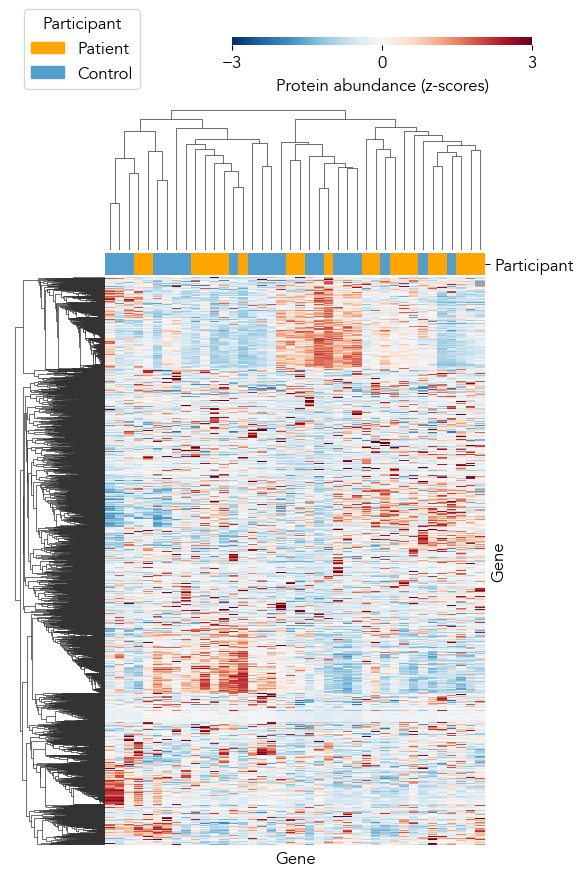

In [190]:
min_color = -3
max_color = 3

hm_average = sns.clustermap(data=df_nolabels,
          method="average",
          metric="correlation",
          xticklabels=[],
          yticklabels=[],
          vmin=min_color,
          vmax=max_color,
          cmap="RdBu_r",
          cbar_pos=(0.4, 1.05, 0.50, 0.01),
          cbar_kws={'orientation': 'horizontal', 'ticks': [min_color, 0, max_color], 'label': 'Protein abundance (z-scores)'},
          col_colors=col_colors,
          figsize=(6, 8))

legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=legend_patches, loc='center', bbox_to_anchor=(-0.50, -0.50), title="Participant")
plt.rcParams.update({'font.family': 'sans-serif', 'font.sans-serif': 'Avenir'})

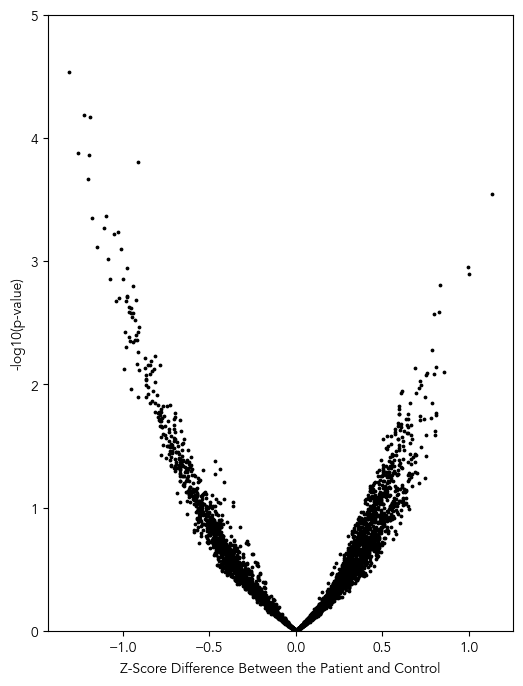

In [206]:
from statsmodels.stats.multitest import multipletests


# create a df of the df dataframe of the columns that are participant row = "patient"
patient_df = df_transposed[df_transposed['Participant'] == 'Patient']
patient_df = patient_df.drop('Participant', axis=1)
patient_df = patient_df.reset_index(drop=True)

# create a df of the df dataframe of the rows that are participant row = "control"
control_df = df_transposed[df_transposed['Participant'] == 'Control']
control_df = control_df.drop('Participant', axis=1)

# compute p-value w a two-tailed, equal variance Student's t-test
patient_df = patient_df.apply(pd.to_numeric, errors='coerce')
control_df = control_df.apply(pd.to_numeric, errors='coerce')
t_stat, p_values = ttest_ind(patient_df, control_df, equal_var=True, axis=0)

# Calculate log2 fold change (x-axis)
log2_fold_change = (control_df.mean(axis=0)-patient_df.mean(axis=0))

# perform Benjamini-Hochberg correction
# corrected_p_values = multipletests(p_values, method='fdr_bh', alpha=0.05)[1]

# Calculate -log10 of p_value (y-axis)
minus_log10_p_value= -np.log10(p_values)

# # Create figure
plt.figure(figsize=(6, 8))
plt.rcParams.update({'font.size': 10, 'font.family': 'sans-serif', 'font.sans-serif': 'Avenir'})

plt.scatter(log2_fold_change, minus_log10_p_value, color='black', s=3)
plt.xlabel('Z-Score Difference Between the Patient and Control')
plt.ylabel('-log10(p-value)')

# plt.xlim(-2, 2)
plt.ylim(0, 5)
plt.show()

In [192]:
print(len(log2_fold_change))
print(len(minus_log10_p_value))

4735
4735


In [193]:
control_df

Gene,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAGAB,AARS,AASDHPPT,ABCC6,...,ZNF774,ZNF843,ZNRF3,ZP4,ZPBP,ZPBP2,ZPLD1,ZWILCH,ZWINT,ZYX
Gene,,,,,,,,,,,,,,,,,,,,,
C1,0.091205,-0.366126,-1.446105,-0.549432,-0.536944,-0.299501,-0.292182,-0.820226,-0.587184,-0.819323,...,0.160500,-0.754402,-0.207058,0.080058,0.843044,-0.394226,0.169830,1.073171,-0.474608,-1.442735
C2,7.078895,-0.189053,0.419728,-0.361978,0.003758,-0.228679,-0.949040,-0.855227,-0.900711,-0.286599,...,-0.285183,-0.231702,0.213650,0.145059,0.251875,-0.187077,0.733269,0.101965,-0.240045,1.236425
C3,1.069358,-0.191105,0.994347,0.448254,-0.982690,0.026621,-1.024670,-0.842347,-1.039194,-1.054956,...,0.584928,-0.718431,-0.022314,0.891907,1.223247,-1.032870,-0.064138,0.978747,-0.256897,-0.461370
C4,-0.410483,-0.447277,0.976399,-0.608533,0.058020,-0.271733,-0.146542,-0.475757,-0.593619,-0.152482,...,-0.702408,-0.438253,-0.096045,0.068312,0.564090,0.442088,0.053915,1.129730,0.674238,1.033261
C5,0.090994,-0.284493,-0.790543,0.232591,-0.989209,-0.150768,-0.911654,-0.637662,-0.770396,0.531415,...,0.916792,1.699661,-0.181916,-0.083498,2.361521,-1.254042,-0.254261,1.329205,0.231543,-0.825308
C8,-0.391397,-0.293338,-0.042582,-0.514884,-1.274313,-0.337742,-0.596134,-0.600139,0.039612,-0.084929,...,0.826742,0.227097,-0.317169,0.094485,-0.579469,-0.372421,-0.435583,-0.540338,-0.765723,-0.616618
C9,-0.482971,-0.274342,-0.595659,-0.505113,-0.747419,-0.189681,-0.652587,-0.548021,-0.779703,-0.435080,...,0.562107,-0.354712,-0.282411,-0.258266,0.428934,-0.300965,0.099608,0.981353,-0.486870,-0.646738
C11,0.155578,-0.461104,-0.083005,0.029682,-0.468004,-0.213198,-0.468214,-0.374098,-0.073537,-1.128378,...,0.993073,-1.011909,-0.214178,-0.168294,0.547770,-0.504577,-0.272006,0.572758,-0.678586,0.322707
C14,0.292637,-0.713775,-1.679806,-0.819734,-0.820285,-0.420879,1.022425,0.395356,0.956157,-0.724259,...,-0.229078,-0.614061,-0.314105,-0.328098,0.353571,-0.698374,6.092002,0.461969,-0.057444,0.302116


# Enrichment analysis

In [194]:
# amongst all Participants = Patient, find the top 20 with the highest mean value
df_patient = df.loc[:, df.loc['Participant'] == 'Patient']
df_patient = df_patient.drop('Participant')
df_patient = df_patient.apply(pd.to_numeric)
df_patient = df_patient.mean(axis=1)
df_patient = df_patient.sort_values(ascending=False)
df_patient = df_patient.head(20)

In [207]:
# get bottom 20
df_patient_bottom = df.loc[:, df.loc['Participant'] == 'Patient']
df_patient_bottom = df_patient_bottom.drop('Participant')
df_patient_bottom = df_patient_bottom.apply(pd.to_numeric)
df_patient_bottom = df_patient_bottom.mean(axis=1)
df_patient_bottom = df_patient_bottom.sort_values(ascending=True)
df_patient_bottom = df_patient_bottom.head(20)

In [208]:
df_patient_bottom

Gene
SEMA4A                              -0.612139
CFTR                                -0.533922
IL19                                -0.502659
DIXDC1                              -0.490757
ENPP5                               -0.440912
G6B                                 -0.440503
GLP1R                               -0.438528
STK17B                              -0.437726
EIF3J                               -0.436094
SEMA4D                              -0.430270
SKP1                                -0.427734
IGHG1 IGHG2 IGHG3 IGHG4 IGK@ IGL@   -0.419248
BRDT                                -0.414500
PCDHGB1                             -0.405587
MSTN                                -0.401800
NMT1                                -0.399565
EGF                                 -0.398360
apcA apcB                           -0.397717
NRCAM                               -0.395102
ARPC3                               -0.394648
dtype: float64

In [195]:
df_patient

Gene
AIF1L       0.713905
TNFRSF1A    0.660167
EFNA4       0.653608
PPIC        0.649365
ROR1        0.642501
CRABP2      0.638695
IL18BP      0.633991
IL15RA      0.611514
GDF15       0.598092
TPPP2       0.596133
PXDN        0.585887
NBL1        0.583916
HSPB6       0.577347
UNC5B       0.576397
SELM        0.563590
XXYLT1      0.563154
EFNA5       0.557503
TIMP1       0.552045
FABP4       0.547796
DCP1A       0.544315
dtype: float64

In [196]:
# get list of unique genes
genes = df.index[:-1].unique().sort_values(ascending = True)
genes

Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAGAB', 'AARS',
       'AASDHPPT', 'ABCC6',
       ...
       'ZPBP2', 'ZPLD1', 'ZWILCH', 'ZWINT', 'ZYX', 'apcA apcB', 'magainins',
       'mdh', 'nodH', 'non-human'],
      dtype='object', name='Gene', length=4735)

In [197]:
df_nolabels_t = df_nolabels.T
corr = df_nolabels_t.corr()

In [198]:
corr

Gene,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAGAB,AARS,AASDHPPT,ABCC6,...,ZNF774,ZNF843,ZNRF3,ZP4,ZPBP,ZPBP2,ZPLD1,ZWILCH,ZWINT,ZYX
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,1.000000,-0.083510,-0.022669,0.203771,0.122994,-0.007841,-0.269073,-0.241906,-0.348681,-0.218932,...,0.148405,0.003962,0.301280,0.112852,0.319800,0.036129,0.280746,0.307256,0.186326,-0.135460
A1CF,-0.083510,1.000000,0.407747,0.221993,0.218914,-0.055605,0.061951,0.354974,0.166737,0.154306,...,-0.094243,0.067286,-0.013942,-0.195319,-0.292473,0.388332,-0.072033,-0.239737,-0.182738,0.058857
A2M,-0.022669,0.407747,1.000000,0.128871,0.294520,0.082286,-0.011890,0.232433,0.068839,0.305712,...,-0.258613,0.227116,0.040630,0.093110,-0.455670,0.406987,0.011643,-0.424498,-0.151718,0.143300
A2ML1,0.203771,0.221993,0.128871,1.000000,0.159106,0.061802,-0.370057,-0.053422,-0.289666,0.179053,...,0.029218,0.099397,0.156312,-0.118534,0.093282,0.156958,-0.129420,0.069663,0.097996,-0.184929
A4GALT,0.122994,0.218914,0.294520,0.159106,1.000000,-0.056760,-0.021949,0.018130,-0.127103,0.424760,...,-0.315242,0.333263,0.188933,-0.370637,-0.429502,0.583895,-0.169137,-0.318949,0.082248,-0.302403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZPBP2,0.036129,0.388332,0.406987,0.156958,0.583895,-0.176326,0.032386,0.029829,-0.093637,0.488569,...,-0.237869,0.396208,0.167499,-0.242115,-0.556948,1.000000,0.013106,-0.485386,-0.142926,-0.151552
ZPLD1,0.280746,-0.072033,0.011643,-0.129420,-0.169137,-0.097202,-0.002179,-0.203349,-0.237687,-0.258362,...,-0.086630,0.089783,0.009883,0.545689,0.028927,0.013106,1.000000,0.109972,0.273972,-0.095679
ZWILCH,0.307256,-0.239737,-0.424498,0.069663,-0.318949,0.229687,-0.379440,-0.443417,-0.431516,-0.552883,...,0.511649,-0.347603,0.196587,0.036622,0.925982,-0.485386,0.109972,1.000000,0.348618,-0.253117


In [199]:
# ignoring corr = 1.00, get the top 20 correlations
corr = corr.mask(np.tril(np.ones(corr.shape)).astype(bool))
corr = corr.stack().sort_values(ascending=False)
corr.head(20)

Gene         Gene    
LCAT         UBE2D3      0.998040
FTH1 FTL     FTL         0.996625
LCAT         MFAP3L      0.996246
ARL6         GCK         0.996154
             LCAT        0.995821
             MFAP3L      0.995626
MFAP3L       UBE2D3      0.995047
ARL6         NAALADL1    0.994873
CHFR         MFAP3L      0.994834
ARL6         UBE2D3      0.994593
             PPA2        0.994223
             CHFR        0.994191
GCK          NAALADL1    0.994026
CDK5 CDK5R1  TPM2        0.993802
CHFR         LCAT        0.993555
ARL6         HPGD        0.993545
CHFR         NAALADL1    0.993454
HPGD         PPA2        0.993453
MFAP3L       NAALADL1    0.993343
             PARP16      0.993256
dtype: float64

In [200]:
gene_of_interest = "LCAT"
correlations = corr.loc[:, gene_of_interest]
ranked_correlations = correlations.sort_values(ascending = False)

# export the top 100 correlations to a txt file, keeping column 0 only
ranked_correlations.to_csv(f'top100_correlations_{gene_of_interest}.txt', sep='\t', header=False)

# remove the numbers from the text file
with open(f'top100_correlations_{gene_of_interest}.txt', 'r') as f:
    lines = f.readlines()
    lines = [line.split('\t')[0] for line in lines]
    lines = [line + '\n' for line in lines]
    lines = lines[0:100]

with open(f'top100_correlations_{gene_of_interest}.txt', 'w') as f:
    f.writelines(lines)

# Targeted analysis (box plot)

In [201]:
# df_targeted subsets the df_patient genes from the main df
df_targeted = df.loc[df_patient.index]

# keep top 12
df_targeted = df_targeted.head(12)

# Copy header as a new row
df_targeted.loc['Participant'] = [p[0] for p in df_targeted.columns]

# Replace C with "Control"
# Replace P with "Patient"
df_targeted.loc['Participant'] = df_targeted.loc['Participant'].replace('C', 'Control')
df_targeted.loc['Participant'] = df_targeted.loc['Participant'].replace('P', 'Patient')

df_targeted.index.name = None
df_targeted.columns.name = "Gene"

In [202]:
# tranpose
df_targeted_t = df_targeted.T

df_targeted_t.loc[:, "Sample"] = df_targeted_t.index
df_targeted_long = df_targeted_t.melt(id_vars = ["Participant", "Sample"])
df_targeted_long_rows_to_keep = df_targeted_long.iloc[:, 3].notna()
df_targeted_long = df_targeted_long.loc[df_targeted_long_rows_to_keep]

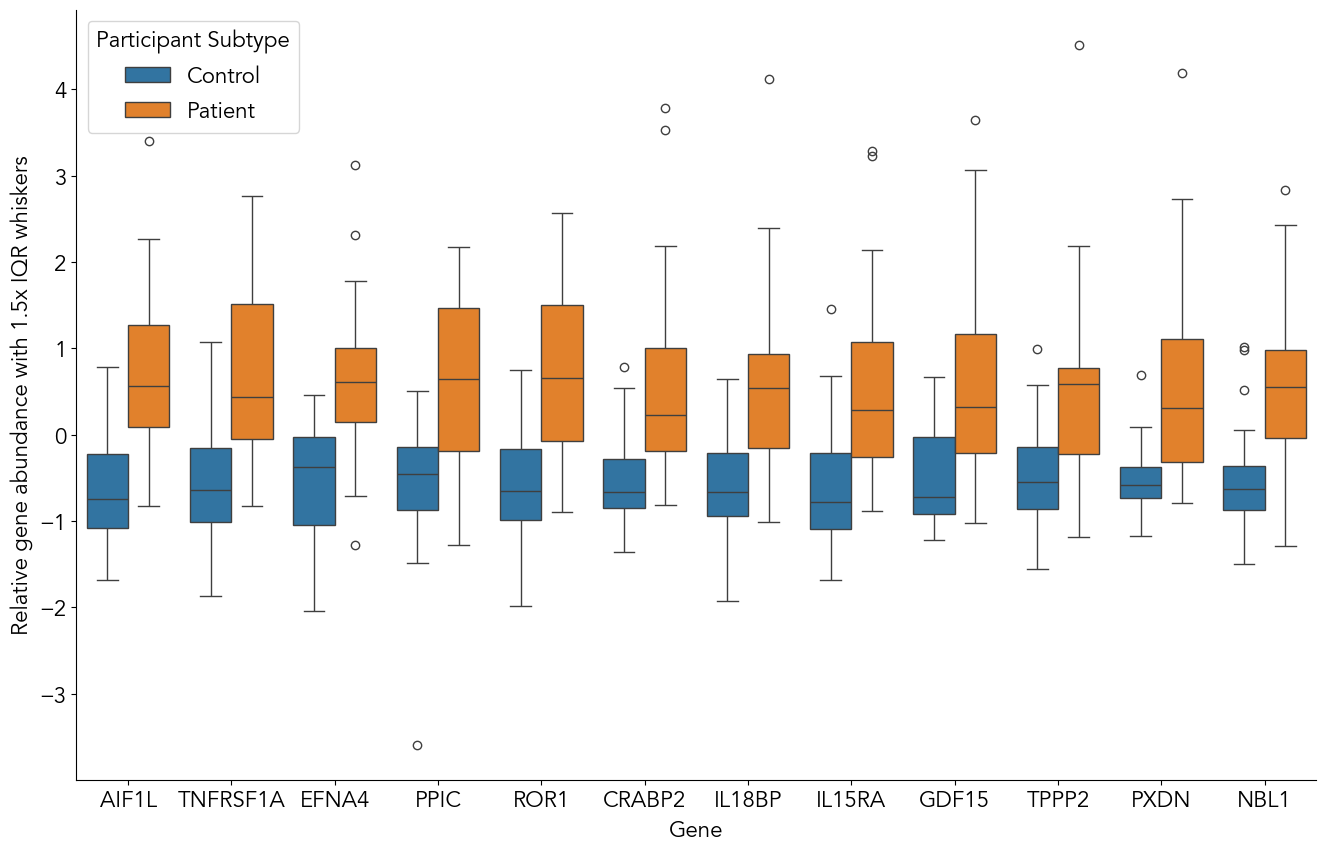

In [203]:
# Set the figure and font size
plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 16, 'font.family': 'sans-serif', 'font.sans-serif': 'Avenir'})

# Create the box plot
sns.boxplot(data=df_targeted_long, x="variable", y="value", hue="Participant")

# Set the x-axis label
plt.xlabel("Gene")
plt.ylabel("Relative gene abundance with 1.5x IQR whiskers")
plt.legend(title="Participant Subtype")
sns.despine()

/Users/briantruan/miniconda3/envs/ns4300/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/briantruan/miniconda3/envs/ns4300/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/briantruan/miniconda3/envs/ns4300/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/briantruan/miniconda3/envs/ns4300/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `

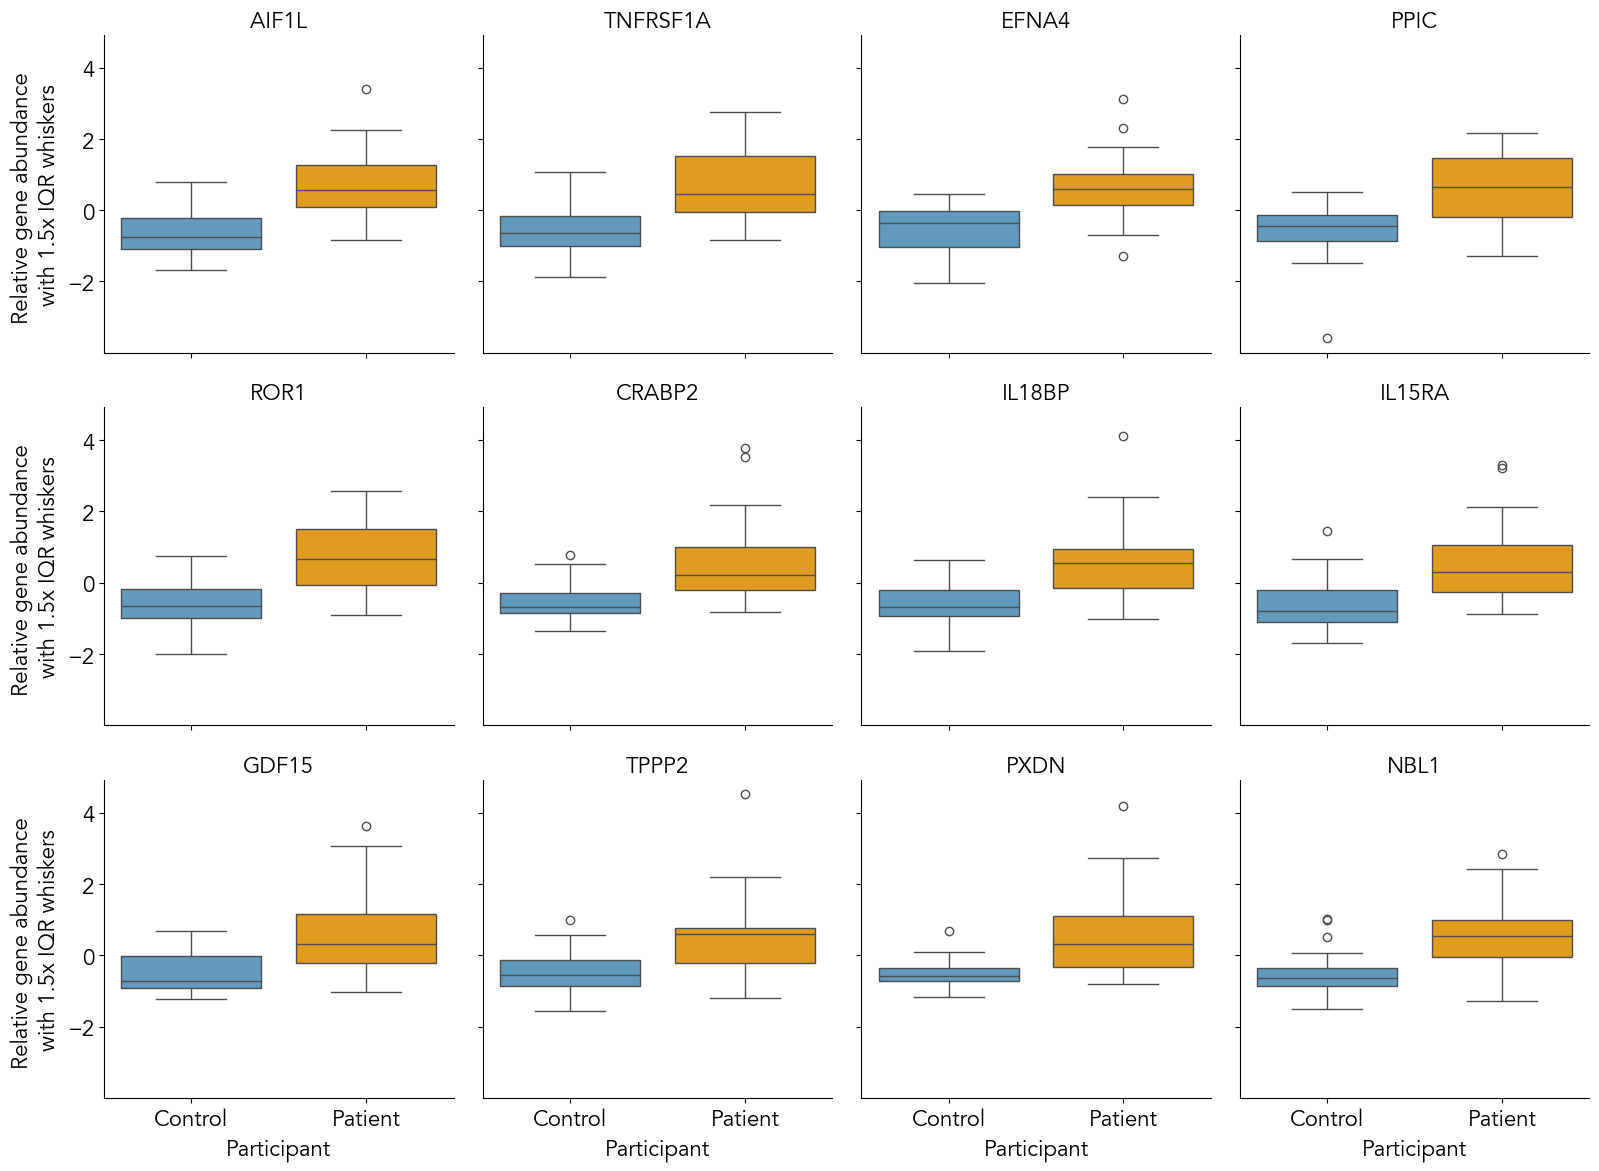

In [204]:
# separate out the boxplots into 10 separate ones and put in a grid format
# box plot colors: patient is orange, control is blue
color_map = {'Patient': 'orange', 'Control': (0.32628988850442137, 0.6186236063052672, 0.802798923490965)}

grid = sns.FacetGrid(df_targeted_long, col="variable", col_wrap=4, height=4, aspect=1)
grid.map(sns.boxplot, "Participant", "value", palette=color_map)
grid.set_titles("{col_name}")
grid.set_axis_labels("Participant", "Relative gene abundance \nwith 1.5x IQR whiskers")
sns.despine()